In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

2024-03-20 13:58:51.637636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 13:58:51.637730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 13:58:51.799680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Function to load data
def load_data(data_dir, target_names):
    img_arr = []
    img_label = []
    label_to_text = {}
    label = 0

    for dir_ in os.listdir(data_dir):
        if dir_ in target_names:
            for f in os.listdir(os.path.join(data_dir, dir_)):
                img = cv2.imread(os.path.join(data_dir, dir_, f), 0)
                img = cv2.resize(img, (48, 48))  # Resize image to 48x48
                img_arr.append(np.expand_dims(img, axis=2))
                img_label.append(label)
            print(f"loaded {dir_} images to numpy arrays...")
            label_to_text[label] = dir_
            label += 1

    img_arr = np.array(img_arr)
    img_label = np.array(img_label)
    img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

    return img_arr, img_label, label_to_text

In [ ]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load training data
data_dir_train = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/train/"
img_arr_train, img_label_train, label_to_text_train = load_data(data_dir_train, target_names)

# Load test data
data_dir_test = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/test/"
img_arr_test, img_label_test, label_to_text_test = load_data(data_dir_test, target_names)

INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(target_names)

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
total_images_train = 0
for dir_ in os.listdir(data_dir_train):
    if dir_ in target_names:
        count = 0
        for f in os.listdir(data_dir_train + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of training images")
        total_images_train += count

print(f"\ntotal training images are {total_images_train}\n")

surprise has 1290 number of training images
fear has 281 number of training images
angry has 705 number of training images
neutral has 2524 number of training images
sad has 1982 number of training images
disgust has 717 number of training images
happy has 4772 number of training images

total training images are 12271



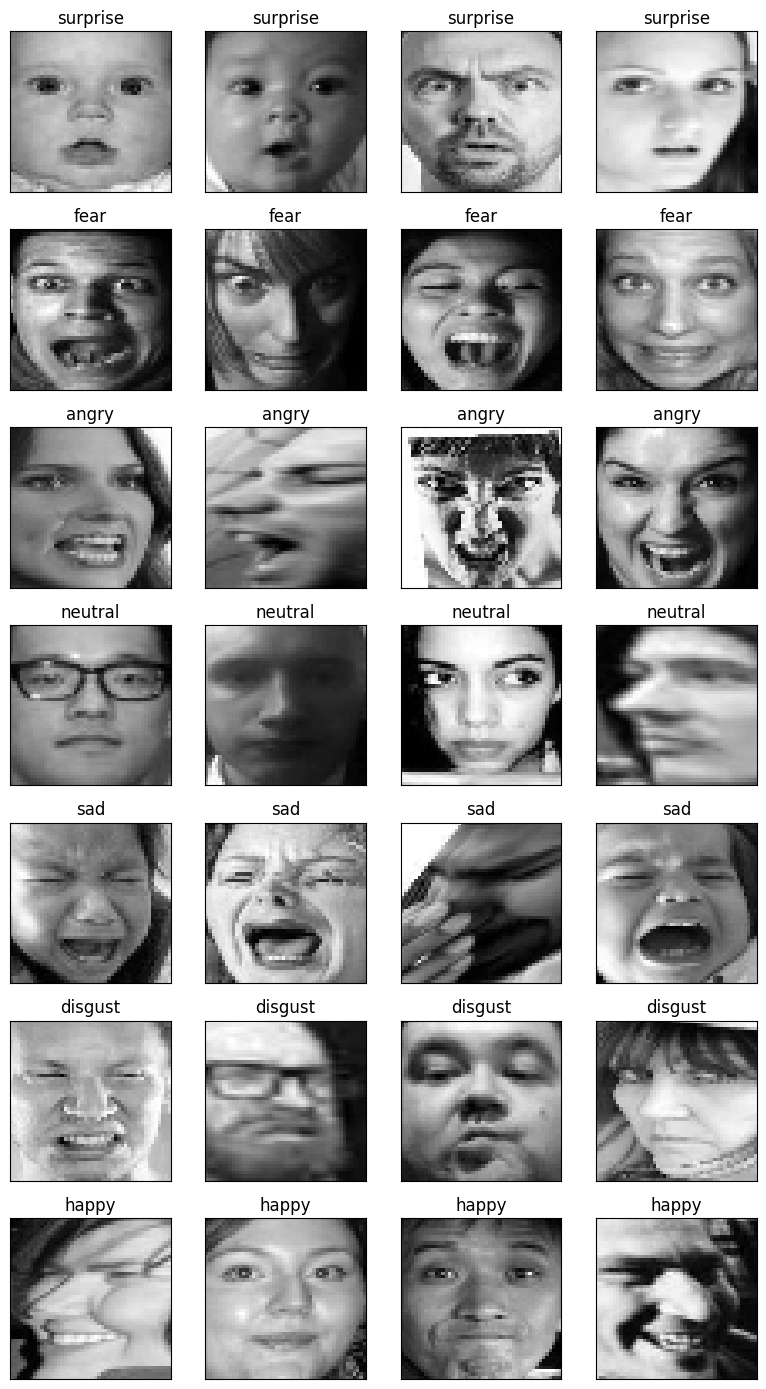

In [ ]:
num_emotions = len(target_names)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text_train:
    sample_indices = np.random.choice(np.where(img_label_train[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr_train[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(48, 48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text_train[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
# Model architecture - XceptionNet
def xception_block_1(X, filters: int, block_id: int, pre_activation=True):
    X_shortcut = X

    actv_id = 1
    if pre_activation:
        X = Activation("relu", name=f"xb1_block{block_id}_actv{actv_id}")(X)
        actv_id += 1

    X = SeparableConv2D(
        filters=filters,
        kernel_size=(3, 3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),
        pointwise_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_sepconv1",
    )(X)
    X = BatchNormalization(name=f"xb1_block{block_id}_bn1")(X)
    X = Activation("relu", name=f"xb1_block{block_id}_actv{actv_id}")(X)

    X = SeparableConv2D(
        filters=filters,
        kernel_size=(3, 3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),
        pointwise_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_sepconv2",
    )(X)
    X = BatchNormalization(name=f"xb1_block{block_id}_bn2")(X)

    X = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding="same",
        name=f"xb1_block{block_id}_maxpool",
    )(X)

    X_residual = Conv2D(
        filters=filters,
        kernel_size=(1, 1),
        strides=(2, 2),
        padding="same",
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_resconv"
    )(X_shortcut)
    X_residual = BatchNormalization(name=f"xb1_block{block_id}_resbn")(X_residual)

    return Add()([X, X_residual])

def xception_block_2(X, block_id: int):
    X_shortcut = X

    for i in range(2):
        X = Activation("relu", name=f"xb2_block{block_id}_actv{i+1}")(X)
        X = SeparableConv2D(
            filters=512,
            kernel_size=(3,3),
            padding="same",
            use_bias=False,
            depthwise_initializer=he_normal(seed=42),
            pointwise_initializer=he_normal(seed=42),
            name=f"xb2_block{block_id}_sepconv{i+1}",
        )(X)
        X = BatchNormalization(name=f"xb2_block{block_id}_bn{i+1}")(X)

    return Add()([X, X_shortcut])

def XceptionNet(in_shape, out_shape, show_summary=False):
    "Shallow implementation of Xception net"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides=(1,1),
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name="conv1"
    )(model_in)
    X = BatchNormalization(name="bn1")(X)
    X = Activation("relu", name="actv1")(X)
    X = Conv2D(
        filters=128,
        kernel_size=(3,3),
        strides=(1,1),
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name="conv2"
    )(X)
    X = BatchNormalization(name="bn2")(X)
    X = Activation("relu", name="actv2")(X)

    X = xception_block_1(X, filters=256, block_id=1, pre_activation=False)
    X = xception_block_1(X, filters=512, block_id=2,)

    for i in range(3):
        X = xception_block_2(X, block_id=i+1)

    X = xception_block_1(X, filters=728, block_id=3,)

    X = SeparableConv2D(
        filters=1024,
        kernel_size=(3,3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),  # Use depthwise_initializer
        pointwise_initializer=he_normal(seed=42),  # Use pointwise_initializer
        name="sepconv",
    )(X)

    X = BatchNormalization(name="bn3",)(X)
    X = Activation("relu", name="actv3",)(X)

    X = GlobalAveragePooling2D()(X)

    X = Dense(units=128, kernel_initializer=he_normal(seed=42), name="dense1")(X)
    X = BatchNormalization(name="bn4")(X)
    X = Activation("relu", name="actv4")(X)

    model_out = Dense(units=out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="XceptionNet")

    if show_summary:
        model.summary()

    return model

Model: "XceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_layer            │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 46, 46,    │        576 │ in_layer[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 46, 46,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actv1 (Activation)  │ (None, 46, 46,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 44, 44,    │     73,728 │ actv1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 44, 44,    │        512 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actv2 (Activation)  │ (None, 44, 44,    │          0 │ bn2[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_sepconv1 │ (None, 44, 44,    │     33,920 │ actv2[0][0]       │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_bn1      │ (None, 44, 44,    │      1,024 │ xb1_block1_sepco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_actv1    │ (None, 44, 44,    │          0 │ xb1_block1_bn1[0… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_sepconv2 │ (None, 44, 44,    │     67,840 │ xb1_block1_actv1… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_bn2      │ (None, 44, 44,    │      1,024 │ xb1_block1_sepco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_resconv  │ (None, 22, 22,    │     32,768 │ actv2[0][0]       │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_maxpool  │ (None, 22, 22,    │          0 │ xb1_block1_bn2[0… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_resbn    │ (None, 22, 22,    │      1,024 │ xb1_block1_resco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ xb1_block1_maxpo… │
│                     │ 256)              │            │ xb1_block1_resbn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block2_actv1    │ (None, 22, 22,    │          0 │ add[0][0]       

 Total params: 4,546,903 (17.35 MB)

 Trainable params: 4,529,095 (17.28 MB)

 Non-trainable params: 17,808 (69.56 KB)

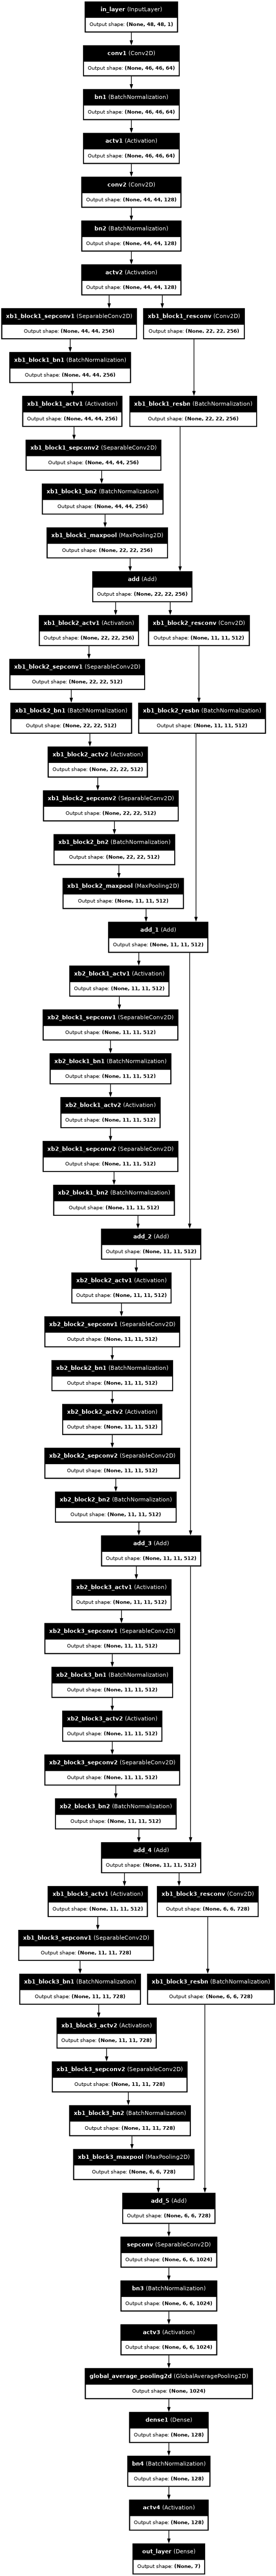

In [ ]:
model = XceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

lr_list:  [0.001, 0.001, 0.001, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 4e-05, 4e-05, 4e-05, 4e-05, 8.000000000000001e-06, 8.000000000000001e-06, 8.000000000000001e-06, 8.000000000000001e-06]


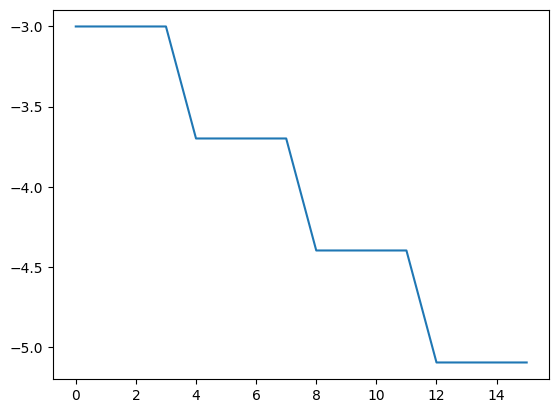

In [ ]:
# Learning rate scheduler functions
def step_lr_scheduler(lr_max, lr_min, step_size, num_stairs, steps_per_stair):
    lr_list = []
    lr = lr_max

    for _ in range(num_stairs):
        for _ in range(steps_per_stair):
            lr_list.append(lr)
        if lr < lr_min:
            lr = lr_min
        else:
            lr *= step_size

    print("lr_list: ", lr_list)

    def lr_scheduler(epoch):
        return lr_list[epoch]

    return lr_scheduler


def cyclic_lr_scheduler(lr_max, lr_min, lr_max_decay, step_size, steps_per_cycle, num_cycles):
    lr_list = []
    lr = lr_max

    for _ in range(num_cycles):
        lr = (
            lr_min
            if lr < lr_min else
            lr_max
        )

        for _ in range(steps_per_cycle):
            lr_list.append(lr)
            lr *= step_size
            if lr < lr_min:
                lr = lr_min

        lr_max *= lr_max_decay

    print("lr_list: ", lr_list)

    def lr_scheduler(epoch):
        return lr_list[epoch]

    return lr_scheduler


epochs = 16
lr_scheduler = step_lr_scheduler(lr_max=1e-3, lr_min=1e-7, step_size=0.2, num_stairs=4, steps_per_stair=4)

# Visualizing the learning rate schedule
lrs = []
for e in range(epochs):
    lrs.append(lr_scheduler(e))

plt.plot(range(epochs), np.log10(lrs))
plt.show()

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)
train_datagen.fit(img_arr_train)

batch_size = 32
epochs = 16

In [ ]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Training the model
history_XceptionNet = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=batch_size),
    validation_data=(img_arr_test, img_label_test),
    steps_per_epoch=int(len(img_arr_train) / batch_size),
    epochs=epochs,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
)

Epoch 1/16


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/383 ━━━━━━━━━━━━━━━━━━━━ 3:28:22 33s/step - accuracy: 0.0625 - loss: 2.2014

I0000 00:00:1710943283.712926     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710943283.752270     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3935 - loss: 1.6523

W0000 00:00:1710943327.952737     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3946 - loss: 1.6493

W0000 00:00:1710943330.537161     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - accuracy: 0.3948 - loss: 1.6489 - val_accuracy: 0.3947 - val_loss: 1.7330 - learning_rate: 0.0010
Epoch 2/16
  1/383 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.4062 - loss: 1.5033

W0000 00:00:1710943337.404919     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4062 - loss: 1.5033 - val_accuracy: 0.3954 - val_loss: 1.7412 - learning_rate: 0.0010
Epoch 3/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.5898 - loss: 1.1306 - val_accuracy: 0.6806 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 4/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7500 - loss: 0.7661 - val_accuracy: 0.6868 - val_loss: 0.9421 - learning_rate: 0.0010
Epoch 5/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.7095 - loss: 0.8151 - val_accuracy: 0.7034 - val_loss: 0.8013 - learning_rate: 2.0000e-04
Epoch 6/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8125 - loss: 0.5419 - val_accuracy: 0.7005 - val_loss: 0.8038 - learning_rate: 2.0000e-04
Epoch 7/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.7394 - loss: 0.7268 - val_accuracy: 0.7536 - val_loss: 0.7008 - learning_rate: 2.0000e-04
Epoch 8/16
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7812 - loss: 0.

In [ ]:
history = pd.DataFrame(history_XceptionNet.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.455920,1.486004,0.394720,1.733034,0.001000
1,0.406250,1.503278,0.395372,1.741226,0.001000
2,0.614348,1.063596,0.680574,0.968173,0.001000
3,0.750000,0.766144,0.686767,0.942060,0.001000
4,0.715336,0.798215,0.703390,0.801310,0.000200
5,0.812500,0.541887,0.700456,0.803784,0.000200
6,0.744914,0.715142,0.753585,0.700801,0.000200
7,0.781250,0.634295,0.750652,0.707060,0.000200
8,0.777596,0.634824,0.779661,0.624196,0.000040
9,0.750000,0.498826,0.780639,0.622863,0.000040


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

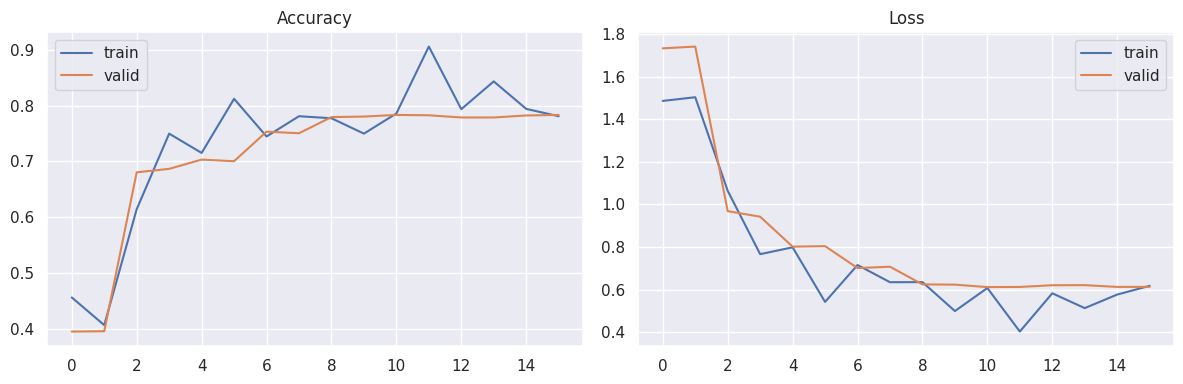

In [ ]:
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['accuracy'], label='train')
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['loss'], label='train')
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

384/384 - 9s - 24ms/step - accuracy: 0.8120 - loss: 0.5291


W0000 00:00:1710943610.107774     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.8119957447052002
96/96 - 2s - 21ms/step - accuracy: 0.7836 - loss: 0.6125

Test Accuracy: 0.7835723757743835
11/96 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1710943613.728372     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


W0000 00:00:1710943617.156490     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       angry       0.82      0.76      0.79       329
     disgust       0.59      0.47      0.53        74
        fear       0.61      0.73      0.66       162
       happy       0.77      0.74      0.75       680
     neutral       0.63      0.82      0.71       478
         sad       0.49      0.26      0.34       160
    surprise       0.92      0.90      0.91      1185

    accuracy                           0.78      3068
   macro avg       0.69      0.67      0.67      3068
weighted avg       0.79      0.78      0.78      3068



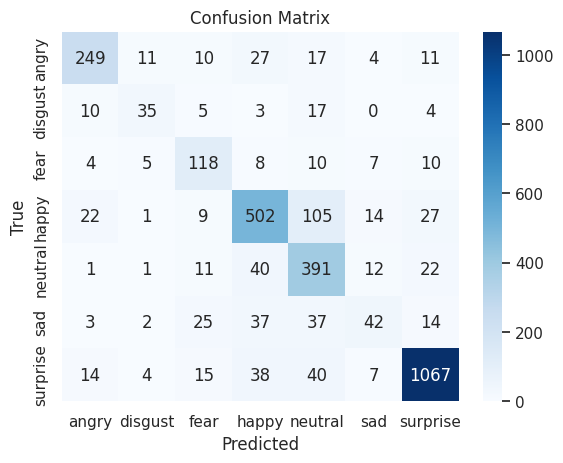

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(img_arr_train, img_label_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(img_arr_test, img_label_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(img_arr_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(img_label_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

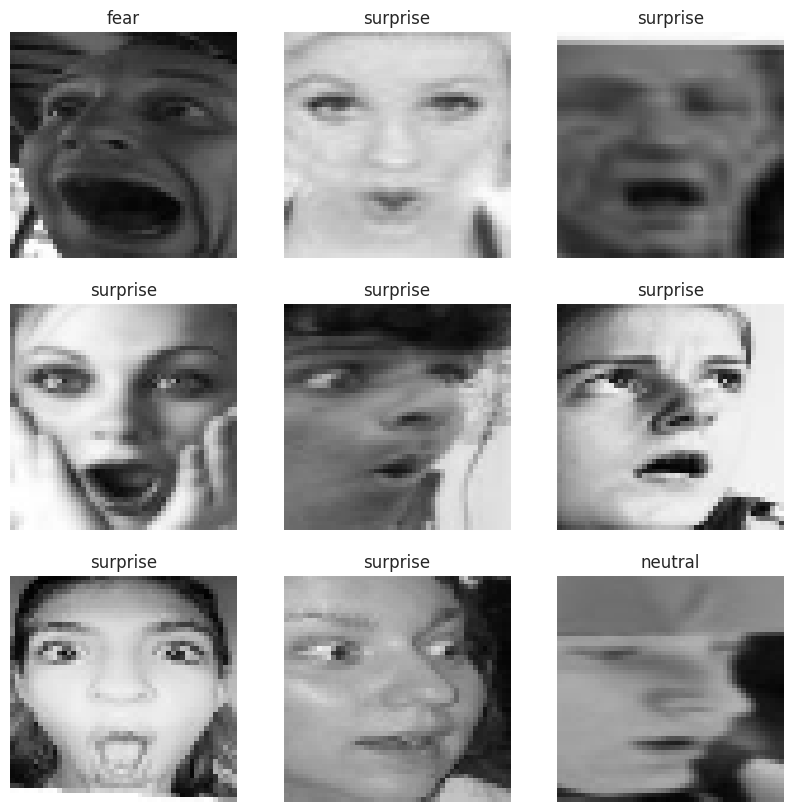

In [ ]:
# Visualize some predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rgb_img = cv2.cvtColor(img_arr_test[i], cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.title(label_to_text_test[predicted_labels[i]])
    plt.axis("off")

plt.show()